<h1 style="text-align:center">Assignment2-Part A </h1>

<font size=5 color=blue > 1. Data preparation and exploration

<font size=4 color=blue >  1.1.1 & 1.1.2 Creating Spark session

In [2]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on the machine
master = "local[*]"
# The appName
app_name = "Assignment2_A"
# Setup configuration parameters for Spark, changing the max partition byte configuration to 20M
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes",1024*1024*20)

# Import SparkSession classes and other libraries 
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import csv

#Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [3]:
spark

<font size=4 color=blue > 1.2 Loading the data

<font size=3 color=blue > 1.2.1

In [4]:
#load the memory activity data into the spark dataframe and cache the data
linux_memory_DF = spark.read.format('csv')\
            .option('header',True).option('inferSchema',True)\
            .load('./linux_memory*').cache()

In [5]:
#load the process activity data into the spark dataframe and cache the data
linux_process_DF = spark.read.format('csv')\
            .option('header',True).option('inferSchema',True)\
            .load('./linux_process*').cache()

In [6]:
print('The number of memory dataframe partitions: ',linux_memory_DF.rdd.getNumPartitions())

The number of memory dataframe partitions:  6


In [7]:
print('The number of process dataframe partitions: ',linux_process_DF.rdd.getNumPartitions())

The number of process dataframe partitions:  7


In [8]:
linux_memory_DF.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [9]:
linux_process_DF.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



### Discussion:
These columns ['MINFLT','MAJFLT', 'VSTEXT','RSIZE', 'VGROW','RGROW'] do not comply with the schema, but they already are String type(see above), and I will transform them into the proper format in step 1.2.2.

<font size=3 color=blue > 1.2.2

In [10]:
# check the null data of memory dataframe, reference the code from week6 lab
from pyspark.sql.functions import isnan, when, count, col
linux_memory_DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_memory_DF.columns])\
.toPandas()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# check the null data of linux_process dataframe, reference the code from week6 lab
linux_process_DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_process_DF.columns])\
.toPandas()

,ts,PID,TRUN,TSLPI,TSLPU,POLI,NICE,PRI,RTPR,CPUNR,Status,EXC,State,CPU,CMD,attack,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
#show the row count of memory activity dataframe
print("The row count of linux memory dataframe: ",linux_memory_DF.count())

The row count of linux memory dataframe:  2000000


In [13]:
#show the row count of process activity dataframe
print("The row count of linux process dataframe: ",linux_process_DF.count())

The row count of linux process dataframe:  1927968


### Discussion:
The data types of columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW','RGROW' are String type, do not follow the datatype from the metadata file, so need to change these types into proper formats.

In [14]:
#In the memory data frame, There are some characters that represent numbers, see the table below，for example: K ,M.
#I randomly selected a row containing these characters to show
linux_memory_DF[linux_memory_DF['ts']==1556230921].show()

+----------+-----+------+------+------+-----+-----+-----+-----+---+--------+------+----+
|        ts|  PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|     CMD|attack|type|
+----------+-----+------+------+------+-----+-----+-----+-----+---+--------+------+----+
|1556230921|20085|  132K|224.4M|11180K|  0.0|   0K|   0K|   0K|0.0| apache2|     1|ddos|
|1556230921| 2355|   132| 382.8|  9164|  0.0|    0|   96| 6468|0.0|vmtoolsd|     1| dos|
+----------+-----+------+------+------+-----+-----+-----+-----+---+--------+------+----+



In [15]:
# reference the code from https://www.bmc.com/blogs/how-to-write-spark-udf-python/
# write a UDF function to transform the 'K, M, G' to the proper values
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, DoubleType

colsDouble = udf(lambda x: toDouble(x), DoubleType())
spark.udf.register("colsDouble", colsDouble)

def toDouble(s):
        if s[-1] =='K':
            return float(s[0:-1])*1000
        elif s[-1] =='M':
            return float(s[0:-1])*1000000
        elif s[-1] =='G':
            return float(s[0:-1])*1000000000
        else:
            return float(s)

In [16]:
wrangling_columns = ['MINFLT','MAJFLT','VSTEXT','RSIZE','VGROW','RGROW']

# remove the space
for columns in wrangling_columns:
    linux_memory_DF = linux_memory_DF.withColumn(columns, F.regexp_replace(linux_memory_DF[columns],' ','')) 

# change these types into proper formats 
for columns in wrangling_columns:
    linux_memory_DF = linux_memory_DF.withColumn(columns,colsDouble(columns).cast(DoubleType()))

In [17]:
linux_memory_DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_memory_DF.columns])\
.toPandas()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#After processing, see the table below, the original characters have been converted into corresponding numbers
linux_memory_DF[linux_memory_DF['ts']==1556230921].show()

+----------+-----+--------+-------+-------+-----+-----+-----+------+---+--------+------+----+
|        ts|  PID|  MINFLT| MAJFLT| VSTEXT|VSIZE|RSIZE|VGROW| RGROW|MEM|     CMD|attack|type|
+----------+-----+--------+-------+-------+-----+-----+-----+------+---+--------+------+----+
|1556230921|20085|132000.0|2.244E8|1.118E7|  0.0|  0.0|  0.0|   0.0|0.0| apache2|     1|ddos|
|1556230921| 2355|   132.0|  382.8| 9164.0|  0.0|  0.0| 96.0|6468.0|0.0|vmtoolsd|     1| dos|
+----------+-----+--------+-------+-------+-----+-----+-----+------+---+--------+------+----+



In [19]:
linux_memory_DF.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [20]:
# check again the null value data of memory dataframe
linux_memory_DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in linux_memory_DF.columns])\
.toPandas()

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
linux_memory_DF.toPandas().head(10)

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,attack,type
0,1556743448,2123,9.0,0.0,596.0,191.7,4712.0,0.0,0.0,0.0,apache2,0,normal
1,1556743453,2925,0.0,0.0,350.0,315.3,4596.0,0.0,0.0,0.0,mission-contro,0,normal
2,1556743458,1192,2.0,0.0,1071.0,342.1,4528.0,0.0,0.0,0.0,NetworkManager,0,normal
3,1556743463,1404,0.0,0.0,47.0,505.2,3584.0,0.0,0.0,0.0,whoopsie,0,normal
4,1556743468,3238,0.0,0.0,18.0,368.9,3516.0,0.0,0.0,0.0,deja-dup-monit,0,normal
5,1556743473,3897,1928.0,0.0,148.0,17944.0,2604.0,0.0,0.0,0.0,atop,0,normal
6,1556743478,3894,1927.0,0.0,148.0,17664.0,2480.0,0.0,0.0,0.0,atop,0,normal
7,1556743483,3895,1927.0,0.0,148.0,17644.0,2464.0,0.0,0.0,0.0,atop,0,normal
8,1556743488,3896,1928.0,0.0,148.0,17624.0,2452.0,0.0,0.0,0.0,atop,0,normal
9,1556743493,2433,0.0,0.0,415.0,40368.0,2300.0,0.0,0.0,0.0,dbus-daemon,0,normal


In [22]:
linux_process_DF.toPandas().head(10)

,ts,PID,TRUN,TSLPI,TSLPU,POLI,NICE,PRI,RTPR,CPUNR,Status,EXC,State,CPU,CMD,attack,type
0,1556739928,2579,0,1,0,norm,0,120,0,0,-,0,S,0.00,upstart-dbus-b,0,normal
1,1556739933,3739,0,1,0,norm,0,120,0,0,-,0,S,0.00,kworker/0:1,0,normal
2,1556739938,3752,0,4,0,norm,0,120,0,1,-,0,S,0.00,gnome-terminal,0,normal
3,1556739943,2596,0,4,0,norm,0,120,0,3,-,0,S,0.00,unity-settings,0,normal
4,1556739948,1400,0,1,0,norm,0,120,0,2,-,0,S,0.00,irqbalance,0,normal
5,1556739953,3793,1,10,0,norm,0,120,0,0,-,0,S,1.01,drone,0,normal
6,1556739958,2906,0,5,0,norm,0,120,0,1,-,0,S,0.02,compiz,0,normal
7,1556739963,3790,0,3,0,norm,0,120,0,1,-,0,S,0.02,ostinato,0,normal
8,1556739968,3897,0,1,0,norm,20,100,0,2,-,0,S,0.01,atop,0,normal
9,1556739973,3894,1,0,0,norm,20,100,0,1,-,0,R,0.01,atop,0,normal


<font size=4 color=blue > 1.3 Exploring the data

<font size=3 color=blue > 1.3.1

In [23]:
#show the count of attack and non-attack in memory activity
linux_memory_DF.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [24]:
#show the count of attack and non-attack in process activity
linux_process_DF.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



In [25]:
#show the count of each kind of attack in process avtivity base on the column 'type'
linux_process_DF.filter(F.col('attack') == 1).groupBy('type').count().show()

+---------+-----+
|     type|count|
+---------+-----+
|      xss|17759|
| password|51409|
| scanning|38449|
|     ddos|71603|
|     mitm|  112|
|injection|41311|
|      dos|70721|
+---------+-----+



### Discussion:
According to observations, the non-attack and attack data is an imbalance, in the two data sets of memory and process, the number of non-attack is far more than the number of attacks. On the other hand, the data of various types of attacks are not balanced. Among the process activity attack data, ddos and dos are the two classes with the largest number of attacks, and the number of mitn is the smallest.

<font size=3 color=blue > 1.3.2

In [26]:
# show the basic statistics of memory dataframe numeric columns
Memory_numeric_columns = ['ts','PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM']
linux_memory_DF[Memory_numeric_columns].describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873273192,46453.274152100385,4496.4199664521,23722.88866419944,984.4668735599993,483.17466255000005,0.0033851649999988224
2,stddev,984463.36828451,4887.313351921456,19229.610980642057,1.484287423809912E7,658730.2051543009,9046.338093398996,1986383.1808734883,86174.82585202274,1491.4761059171854,0.010943425779985798
3,min,1554216855,1007,0.0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000.0,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [27]:
# display the top 10 values and the corresponding counts of the non-numeric of memory dataframe 
#the non-numeric column is 'CMD'
linux_memory_DF.groupBy('CMD').agg(F.count('CMD').alias('count')).sort('count',ascending = False).show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



In [28]:
# show the basic statistics of process dataframe numeric columns
Process_numeric_columns = ['ts','PID','TRUN','TSLPI','TSLPU','NICE','PRI','RTPR','CPUNR','EXC','CPU']
linux_process_DF[Process_numeric_columns].describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209765
2,stddev,771350.0248070975,4987.784329320453,0.24782587090416075,6.988459728531831,0.044218744192145915,8.40318986475206,22.62444506210301,0.0,1.5274047225902883,1.4619498567691842,0.13628943687184222
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02


In [29]:
# display the top 10 values and the corresponding counts of the non-numeric of process dataframe 
Process_non_numeric_columns = ['POLI', 'Status', 'State', 'CMD']

for x in Process_non_numeric_columns:
    linux_process_DF.groupBy(x).agg(F.count(x).alias('count')).sort('count',ascending = False).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



<font size=3 color=blue > 1.3.3

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

#using sampling before plotting
Memory_sample_data = linux_memory_DF.sample(fraction = 0.2).toPandas()
Process_sample_data = linux_process_DF.sample(fraction = 0.2).toPandas()

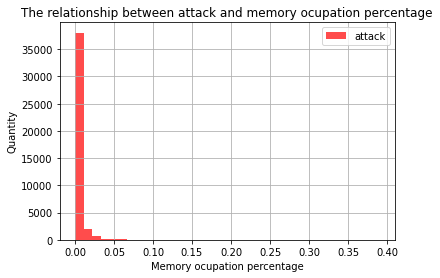

In [31]:
#Memmory activity: analysis the relationship between attack and memory ocupation percentage 
Memory_sample_data[Memory_sample_data['attack'] == 1]['MEM'] \
    .hist(bins =35, color='red',label='attack=1',alpha=0.7)
plt.xlabel("Memory ocupation percentage")
plt.ylabel("Quantity")
plt.title("The relationship between attack and memory ocupation percentage")
plt.legend(['attack'])
plt.show()

### The relationship between attack and memory ocupation percentage
This figure chooses to analyze the relationship between the attack data and the proportion of memory usage. We can see from the histogram figure that among the attacked data, the most memory occupation percentage is still close to zero. It is speculated that the hacker will do not cause excessive memory percentage when performing the attack. 

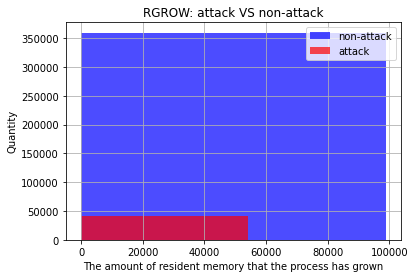

In [32]:
#Memmory activity：The amount of resident memory that the process has grown，attack VS non-attack 
Memory_sample_data[Memory_sample_data['attack'] == 0]['RGROW'] \
    .hist(bins =1, color='blue',label='attack=1',alpha=0.7)
Memory_sample_data[Memory_sample_data['attack'] == 1]['RGROW'] \
    .hist(bins =1, color='red',label='attack=1',alpha=0.7)
plt.xlabel("The amount of resident memory that the process has grown")
plt.ylabel("Quantity")
plt.title("RGROW: attack VS non-attack")
plt.legend(['non-attack','attack'])
plt.show()

### RGROW: attack VS non-attack
As can be seen from this histogram, The range of the amount of resident memory that the process has grown during the last interval of attack is smaller than the non-attack data. It is basically in the range of 0-8000, while the data that is not attacked is in the field of 0-10000.

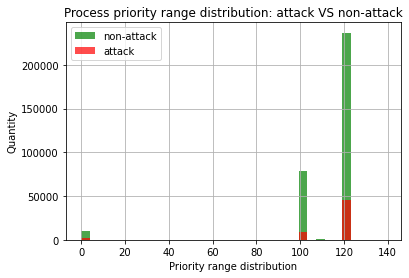

In [33]:
#process activity: Process priority range distribution: attack VS non-attack
Process_sample_data[Process_sample_data['attack'] == 0]['PRI'] \
    .hist(bins =35, color='green',label='not attack=0',alpha=0.7)
Process_sample_data[Process_sample_data['attack'] == 1]['PRI'] \
    .hist(bins =35, color='red',label='not attack=0',alpha=0.7)
plt.xlabel("Priority range distribution")
plt.ylabel("Quantity")
plt.title("Process priority range distribution: attack VS non-attack")
plt.legend(['non-attack','attack'])
plt.show()

### Process priority range distribution: attack VS non-attack
It can be observed from this figure that the distribution of the attack data and the non-attack data is relatively similar, and the process priority of the attacked data is mostly concentrated at a relatively low priority level. It is speculated that hackers will simulate normal operations in order to prevent users from easily discovering during the attack.

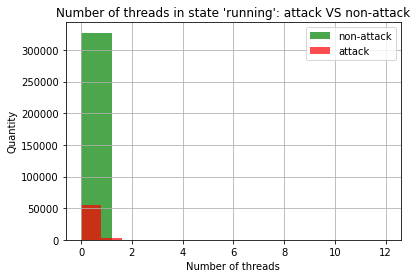

In [34]:
#process activity: Number of threads in state 'running': attack VS non-attack
Process_sample_data[Process_sample_data['attack'] == 0]['TRUN'] \
    .hist(bins =10, color='green',label='not attack=0',alpha=0.7)
Process_sample_data[Process_sample_data['attack'] == 1]['TRUN'] \
    .hist(bins =10, color='red',label='not attack=0',alpha=0.7)
plt.xlabel("Number of threads")
plt.ylabel("Quantity")
plt.title("Number of threads in state 'running': attack VS non-attack")
plt.legend(['non-attack','attack'])
plt.show()

### Number of threads in state 'running': attack VS non-attack
As can be seen from this figure, among the quantity of data under attack, the number of threads in state 'running' is 0, which has the most amount. 

<font size=5 color=blue > 2.Feature extraction and ML training

<font size=4 color=blue > 2.1 Preparing the training data and testing data

<font size=3 color=blue > 2.1.1

In [35]:
# splitting the data as training and test data for memory dataframe
Memory_train, Memory_test = linux_memory_DF.randomSplit([0.8, 0.2], seed=12345)

In [36]:
# splitting the data as training and test data for process dataframe
Process_train, Process_test = linux_process_DF.randomSplit([0.8, 0.2], seed=12345)

<font size=3 color=blue > 2.1.2

In [37]:
#memory activity,using 20% attack events data from the training data
Attack_memory_train = Memory_train.filter(F.col('attack') == 1).sample(0.2, seed=123456)
#calculate the ratio
Memory_non_attack_ratio = Attack_memory_train.count()*2/Memory_train.filter(F.col('attack') == 0).count()
#get the non-attack training data
Non_attack_memory_train = Memory_train.filter(F.col('attack') == 0).sample(Memory_non_attack_ratio, seed=123456)

In [38]:
print(Attack_memory_train.count())
print(Non_attack_memory_train.count())

32817
65587


In [39]:
#combine the attack and non-attack data
Rebalanced_memory_train = Attack_memory_train.union(Non_attack_memory_train).cache()

In [40]:
#Display the count of memory activity data
Rebalanced_memory_train.groupBy('attack').agg(F.count("attack").alias('count')).show()

+------+-----+
|attack|count|
+------+-----+
|     1|32817|
|     0|65587|
+------+-----+



In [41]:
#process activity,,using 20% attack events data from the training data
Attack_process_train = Process_train.filter(F.col('attack') == 1).sample(0.2, seed=1234567)
#calculate the ratio
Process_non_attack_ratio = Attack_process_train.count()*2/Process_train.filter(F.col('attack') == 0).count()
#get the non-attack training data
Non_attack_process_train = Process_train.filter(F.col('attack') == 0).sample(Process_non_attack_ratio, seed=1234567)

In [42]:
print(Attack_process_train.count())
print(Non_attack_process_train.count())

46758
93753


In [43]:
#combine the attack and non-attack data
Rebalanced_process_train = Attack_process_train.union(Non_attack_process_train).cache()

In [44]:
#Display the count of process activity data
Rebalanced_process_train.groupBy('attack').agg(F.count("attack").alias('count')).show()

+------+-----+
|attack|count|
+------+-----+
|     1|46758|
|     0|93753|
+------+-----+



<font size=4 color=blue > 2.2 Preparing features,labels and models

In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier

<font size=3 color=blue > 2.2.1

## Discussion:  

### About the memory activity: 
1.Because the two columns of 'attack' and 'type' are labels, so that exclude these two columns as features. 
2.The column'ts' will not be used as a feature either, because it is meaningless to predict a cyber attack by a simple timestamp. 
3.The 'CMD' column is a String type and the content of this column is mainly the name of the process. So I don't use this column to be the feature. I tried to use this column as a feature. After encoding it, it became a lot of features, which is very difficult to manage.
4.I think that the remaining columns can be used as features. For example, the column'MEM' shown in the histogram above, regarding the percentage of memory usage, will reflect the memory status under attack to a certain extent.
5.In this activity, because the column "CMD" is not used as a feature, the rest are numeric columns, so I will not use Stringindexer and one Hot Encoder in the feature encoding process.

### About the process activity:  
1.With the same reason above,because the two columns of 'attack' and 'type' are labels, so that exclude these two columns as features.the 'ts' and 'CMD' columns are meaningless.
2.I will use the remaining columns as features, because when under attack, CPU consumption, process priority, etc. will show some different characteristics.
3.In this activity, I will use StringIndexer for the columns of the String type, and after the conversion is completed, the One Hot Encoder will be performed on the columns of the numeric type. This is completely different from the memory activity. And I am curious how much impact the use of StringIndexer, One Hot Encoder has on model performance.

<font size=3 color=blue > 2.2.2 & 2.2.3

In [46]:
#features selected
#Memory activity
Selected_Memory_numeric_columns = ['PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM']
#Process activity
Selected_Process_numeric_columns = ['PID','TRUN','TSLPI','TSLPU','NICE','PRI','RTPR','CPUNR','EXC','CPU']
Selected_Process_non_numeric_columns = ['POLI', 'Status', 'State']

In [47]:
'''
Memory activity: 
Create Transformation, Estimators for transforming, assembling the features selected above.
Regarding Memory activity, because only the 'CMD' column is a String type and the content of this column 
is mainly the name of the process. So I don't use this column to be the feature and not do the Stringindexer 
and one hot encoder.

'''

#Stage 1: Vector Assembler
M_VectorAssembler_inputs = Selected_Memory_numeric_columns
M_Assembler = VectorAssembler(inputCols = M_VectorAssembler_inputs, outputCol="features").setHandleInvalid("skip")

#Stage 2: DT & GBT modeling
Memory_DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 5)
Memory_GBT = GBTClassifier(featuresCol = 'features', labelCol = 'attack', maxIter=5)

#Stage 3: plug the stages into the pipline
M_DT_pipeline = Pipeline(stages=[M_Assembler,Memory_DT])
M_GBT_pipeline = Pipeline(stages=[M_Assembler,Memory_GBT])

In [48]:
#Process activity，Create Transformation, Estimators for transforming, assembling the features selected above.
#Stage 1:String Indexer
P_inputCols=[x for x in Selected_Process_non_numeric_columns]
P_outputCols=[f'{x}_index' for x in Selected_Process_non_numeric_columns]
P_indexer = StringIndexer(inputCols = P_inputCols, outputCols = P_outputCols).setHandleInvalid("skip")

#Stage 2: One Hot Encoder
P_inputCols_OHE = [x for x in P_outputCols]
P_outputCols_OHE = [f'{x}_vec' for x in P_inputCols]
P_encoder = OneHotEncoder(inputCols = P_inputCols_OHE, outputCols = P_outputCols_OHE)

#Stage 3: Vector Assembler
P_VectorAssembler_inputs = Selected_Process_numeric_columns + P_outputCols_OHE
P_Assembler = VectorAssembler(inputCols = P_VectorAssembler_inputs, outputCol="features").setHandleInvalid("skip")

#Stage 4: DT & GBT modeling
Process_DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 5)
Process_GBT = GBTClassifier(featuresCol = 'features', labelCol = 'attack', maxIter=5)

#Stage 5: plug the stages into the pipline
P_DT_pipeline = Pipeline(stages=[P_indexer,P_encoder,P_Assembler,Process_DT])
P_GBT_pipeline = Pipeline(stages=[P_indexer,P_encoder,P_Assembler,Process_GBT])

<font size=4 color=blue > 2.3 Training and evaluation models

<font size=3 color=blue > 2.3.1

In [49]:
#Training model: memory activity
#Use the fit method to train the model with the training data
Memory_DT_MODEL = M_DT_pipeline.fit(Rebalanced_memory_train)
Memory_GBT_MODEL = M_GBT_pipeline.fit(Rebalanced_memory_train)

#get predictions from the test data
Memory_DT_Test = Memory_DT_MODEL.transform(Memory_test)
Memory_GBT_Test = Memory_GBT_MODEL.transform(Memory_test)

In [50]:
#Training model: process activity
#Use the fit method to train the model with the training data
Process_DT_MODEL = P_DT_pipeline.fit(Rebalanced_process_train)
Process_GBT_MODEL = P_GBT_pipeline.fit(Rebalanced_process_train)

#get predictions from the test data
Process_DT_Test = Process_DT_MODEL.transform(Process_test)
Process_GBT_Test = Process_GBT_MODEL.transform(Process_test)

<font size=3 color=blue > 2.3.2

In [51]:
#display the count for Memory_DT_Test
Memory_DT_Test.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 20863|
|     0|       0.0|302477|
|     1|       1.0| 20187|
|     0|       1.0| 55755|
+------+----------+------+



In [52]:
#display the count for Memory_GBT_Test
Memory_GBT_Test.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 20027|
|     0|       0.0|315401|
|     1|       1.0| 21023|
|     0|       1.0| 42831|
+------+----------+------+



In [53]:
#display the count for Process_DT_Test
Process_DT_Test.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 29263|
|     0|       0.0|278505|
|     1|       1.0| 28970|
|     0|       1.0| 48135|
+------+----------+------+



In [54]:
#display the count for Process_GBT_Test
Process_GBT_Test.groupBy('attack', 'prediction').count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 28297|
|     0|       0.0|277540|
|     1|       1.0| 29936|
|     0|       1.0| 49100|
+------+----------+------+



<font size=3 color=blue > 2.3.3

In [55]:
#fuction for calculate the accuracy, precision,recall and f1, Reference the code from week6 lab
def compute_metrics(predictions):
    #WRITE CODE: to calculate accuracy,precision,recall and f1 based on above example
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()
    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count()
    
    accuracy = print("accuracy: ", ((TP+TN) / (TP+TN+FP+FN)))
    precision = print("precision: ",(TP / (TP + FP)))
    recall = print("recall: ",(TP / (TP + FN)))
    f1 = print("f1: ",(2/ (1/(TP / (TP + FN)) + 1/(TP / (TP + FP)))))  

In [56]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate models
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="attack")
Memory_DT_auc = evaluator.evaluate(Memory_DT_Test)
Memory_GBT_auc = evaluator.evaluate(Memory_GBT_Test)
Process_DT_auc = evaluator.evaluate(Process_DT_Test)
Process_GBT_auc = evaluator.evaluate(Process_GBT_Test)

In [57]:
print("The Memory decision tree model")
print("AUC: {}".format(Memory_DT_auc))
compute_metrics(Memory_DT_Test)

The Memory decision tree model
AUC: 0.6211272601831068
accuracy:  0.8081105584524221
precision:  0.26582128466461247
recall:  0.4917661388550548
f1:  0.3451005196936543


In [58]:
print("The Memory GBT model")
print("AUC: {}".format(Memory_GBT_auc))
compute_metrics(Memory_GBT_Test)

The Memory GBT model
AUC: 0.8265278292629393
accuracy:  0.8425724174893935
precision:  0.3292354433551539
recall:  0.5121315468940316
f1:  0.40080454510790814


In [59]:
print("The Process decision tree model")
print("AUC: {}".format(Process_DT_auc))
compute_metrics(Process_DT_Test)

The Process decision tree model
AUC: 0.6837396744937242
accuracy:  0.7988998968490905
precision:  0.37572141884443294
recall:  0.497484244328817
f1:  0.42811331628958615


In [60]:
print("The Process GBT model")
print("AUC: {}".format(Process_GBT_auc))
compute_metrics(Process_GBT_Test)

The Process GBT model
AUC: 0.7966820947669753
accuracy:  0.7989024951087761
precision:  0.3787641074953186
recall:  0.5140727766043309
f1:  0.4361654852880111


### Discussion: 
According to the above model evaluation results, AUC is a measure of the entire model performance, which is more suitable for identifying and predicting network attack data. And we can see that the performance of the Gradient Boosted Tree Model is better than the decision tree model in both two activities. 

<font size=3 color=blue > 2.3.4

In [61]:
#Display The top 5 features of the decision tree model for memory activity
Memory_DT_important_values = Memory_DT_MODEL.stages[-1].featureImportances.toArray().tolist()
features_colums = ['PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM']
Memory_DT_zipped = zip(Memory_DT_important_values,features_colums)
DT_Memory_sort_zipped = sorted(Memory_DT_zipped,key=lambda x:x[0],reverse=True)
print('The Memory_DT_MODEL top 5 features: ',DT_Memory_sort_zipped[:5])

The Memory_DT_MODEL top 5 features:  [(0.3716010563283029, 'PID'), (0.33666206378124425, 'MINFLT'), (0.09130872209330422, 'RGROW'), (0.08429305995313152, 'VSIZE'), (0.07456632149305609, 'VSTEXT')]


In [62]:
#Display The top 5 features of the GBT model for memory activity
Memory_GBT_important_values = Memory_GBT_MODEL.stages[-1].featureImportances.toArray().tolist()
features_colums = ['PID','MINFLT','MAJFLT','VSTEXT','VSIZE','RSIZE','VGROW','RGROW','MEM']
Memory_GBT_zipped = zip(Memory_GBT_important_values,features_colums)
DT_Memory_sort_zipped = sorted(Memory_GBT_zipped,key=lambda x:x[0],reverse=True)
print('The Memory_GBT_Test top 5 features: ',DT_Memory_sort_zipped[:5])

The Memory_GBT_Test top 5 features:  [(0.25374556889007316, 'PID'), (0.2149692836330319, 'MINFLT'), (0.181562597807967, 'VSIZE'), (0.15763552694413452, 'VSTEXT'), (0.1373155297875522, 'RSIZE')]


### Discussion: 
According to the above model evaluation results, we can see that the performance of the Gradient Boosted Tree Model is better than the decision tree model in memory activity.
Through the display of the top 5 features, we can clearly see that in the memory activity, 'PID' is listed as the most important in the decision tree and GBT models, and features such as'MINFLT' and'RSIZE' are also very important. So that, in the memory activity, we need need to consider the following features: process identifier, the number of page faults issued by this process, and the amount of resident memory etc. The feature of 'ts' should not be used in the model; it is not very meaningful and will affect the performance of the model.

In [63]:
#Display The top 5 features of the decision tree model for process activity
Process_DT_important_values = Process_DT_MODEL.stages[-1].featureImportances.toArray().tolist()
index = list(range(22))
Process_DT_zipped = zip(index,Process_DT_important_values)
DT_process_sort_zipped = sorted(Process_DT_zipped,key=lambda x:x[1],reverse=True)
print('The Process_DT_Test top 5 features index: ',DT_process_sort_zipped[:5])

The Process_DT_Test top 5 features index:  [(0, 0.49971485762543927), (12, 0.3207233508745243), (16, 0.057893590645532726), (11, 0.04568152546666082), (2, 0.04397886367794026)]


In [64]:
#Display The top 5 features of the GBT model for process activity
Process_GBT_important_values = Process_GBT_MODEL.stages[-1].featureImportances.toArray().tolist()
index = list(range(22))
Process_GBT_zipped = zip(index,Process_GBT_important_values)
GBT_process_sort_zipped = sorted(Process_GBT_zipped,key=lambda x:x[1],reverse=True)
print('The Process_GBT_Test top 5 features index: ',GBT_process_sort_zipped[:5])

The Process_GBT_Test top 5 features index:  [(0, 0.4845170150535396), (2, 0.16608306737277018), (12, 0.1271545722951054), (4, 0.08206337245574302), (9, 0.055203088502944433)]


### Discussion: 
According to the above model evaluation results, we can see that the performance of the Gradient Boosted Tree Model is better than the decision tree model in process activity.
Compare the column of features by index. We can see that in this model, the column "PID" is also significant as a feature, and others like "TSLIP" are also very important. In the process activity, we need to consider factors such as process identifier and the number of threads in state'interruptible sleeping'.The feature of 'ts' should not be used in the model; it is not very meaningful and will affect the performance of the model.

In [65]:
# calculate the fpr and tpr values, Reference the code from week6 lab
import numpy as np
import pyspark.sql.functions as F
import pyspark.sql.types as T

def confusion_matrix(Test_data):
     # Calculate the elements of the confusion matrix
    TN = Test_data.filter('prediction = 0 AND attack = 0').count()
    TP = Test_data.filter('prediction = 1 AND attack = 1').count()
    FN = Test_data.filter('prediction = 0 AND attack = 1').count()
    FP = Test_data.filter('prediction = 1 AND attack = 0').count()
    return TP,TN,FP,FN

def fpr_tpr_values(Test_data):
    to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
    df = Test_data.withColumn('probability', to_array('probability'))    
    fpr_value = []
    tpr_value = []
    for threshold in np.linspace(0, 1, 10):
        prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'attack')
        prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
        test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > threshold,1).otherwise(0))
        tp,tn,fp,fn = confusion_matrix(test_df)  
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        fpr_value.append(fpr)
        tpr_value.append(tpr)
    return fpr_value, tpr_value

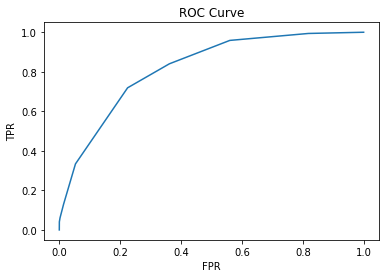

In [66]:
#Visualise the ROC curve for the better model-----> Memory_GBT_Test
fpr_value, tpr_value = fpr_tpr_values(Memory_GBT_Test)
plt.plot(fpr_value, tpr_value)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

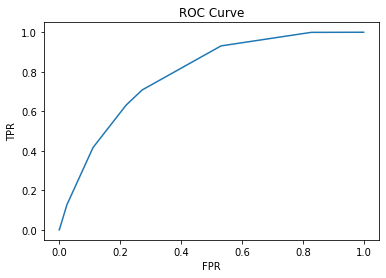

In [67]:
#Visualise the ROC curve for the better model-----> Process_GBT_Test
fpr_value, tpr_value = fpr_tpr_values(Process_GBT_Test)
plt.plot(fpr_value, tpr_value)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

<font size=3 color=blue > 2.3.5

In [68]:
#Memory activity
#using a bigger set training data
Re_Memory_train = linux_memory_DF
#memory activity,select the attack data
Re_Attack_memory_train = Re_Memory_train.filter(F.col('attack') == 1)
#calculate the ratio
Re_Memory_non_attack_ratio = Re_Attack_memory_train.count()*2/Re_Memory_train.filter(F.col('attack') == 0).count()
#get the non-attack training data
Re_Non_attack_memory_train = Re_Memory_train.filter(F.col('attack') == 0).sample(Re_Memory_non_attack_ratio, seed=2020)
#combine the attack and non-attack data
Re_Rebalanced_memory_train = Re_Attack_memory_train.union(Re_Non_attack_memory_train).cache()

In [69]:
#Display the count of memory activity data
Re_Rebalanced_memory_train.groupBy('attack').agg(F.count("attack").alias('count')).show()

+------+------+
|attack| count|
+------+------+
|     1|205623|
|     0|411082|
+------+------+



In [70]:
#re-train the pipeline model: Memory_GBT_MODEL
Memory_GBT_MODEL = M_GBT_pipeline.fit(Re_Rebalanced_memory_train)

In [71]:
#using a bigger set training data
Re_Process_train = linux_process_DF
#memory activity,select the attack data
Re_Attack_Process_train = Re_Process_train.filter(F.col('attack') == 1)
#calculate the ratio
Re_Process_non_attack_ratio = Re_Attack_Process_train.count()*2/Re_Process_train.filter(F.col('attack') == 0).count()
#get the non-attack training data
Re_Non_attack_Process_train = Re_Process_train.filter(F.col('attack') == 0).sample(Re_Process_non_attack_ratio, seed=2020)
#combine the attack and non-attack data
Re_Rebalanced_Process_train = Re_Attack_Process_train.union(Re_Non_attack_Process_train).cache()

In [72]:
#Display the count of process activity data
Re_Rebalanced_Process_train.groupBy('attack').agg(F.count("attack").alias('count')).show()

+------+------+
|attack| count|
+------+------+
|     1|291364|
|     0|582769|
+------+------+



In [73]:
#re-train the pipeline model: Process_GBT_MODEL
Process_GBT_MODEL = P_GBT_pipeline.fit(Re_Rebalanced_Process_train)

<font size=5 color=blue > 3. Knowledge sharing

In [74]:
from pyspark.ml.clustering import KMeans
iris_df = spark.createDataFrame([ (4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

<font size=3 color=blue > 3.1

### Screenshot
When using the above code to train the KMeans cluster model, according to the observation of Spark UI, we can see that there are 10 jobs.

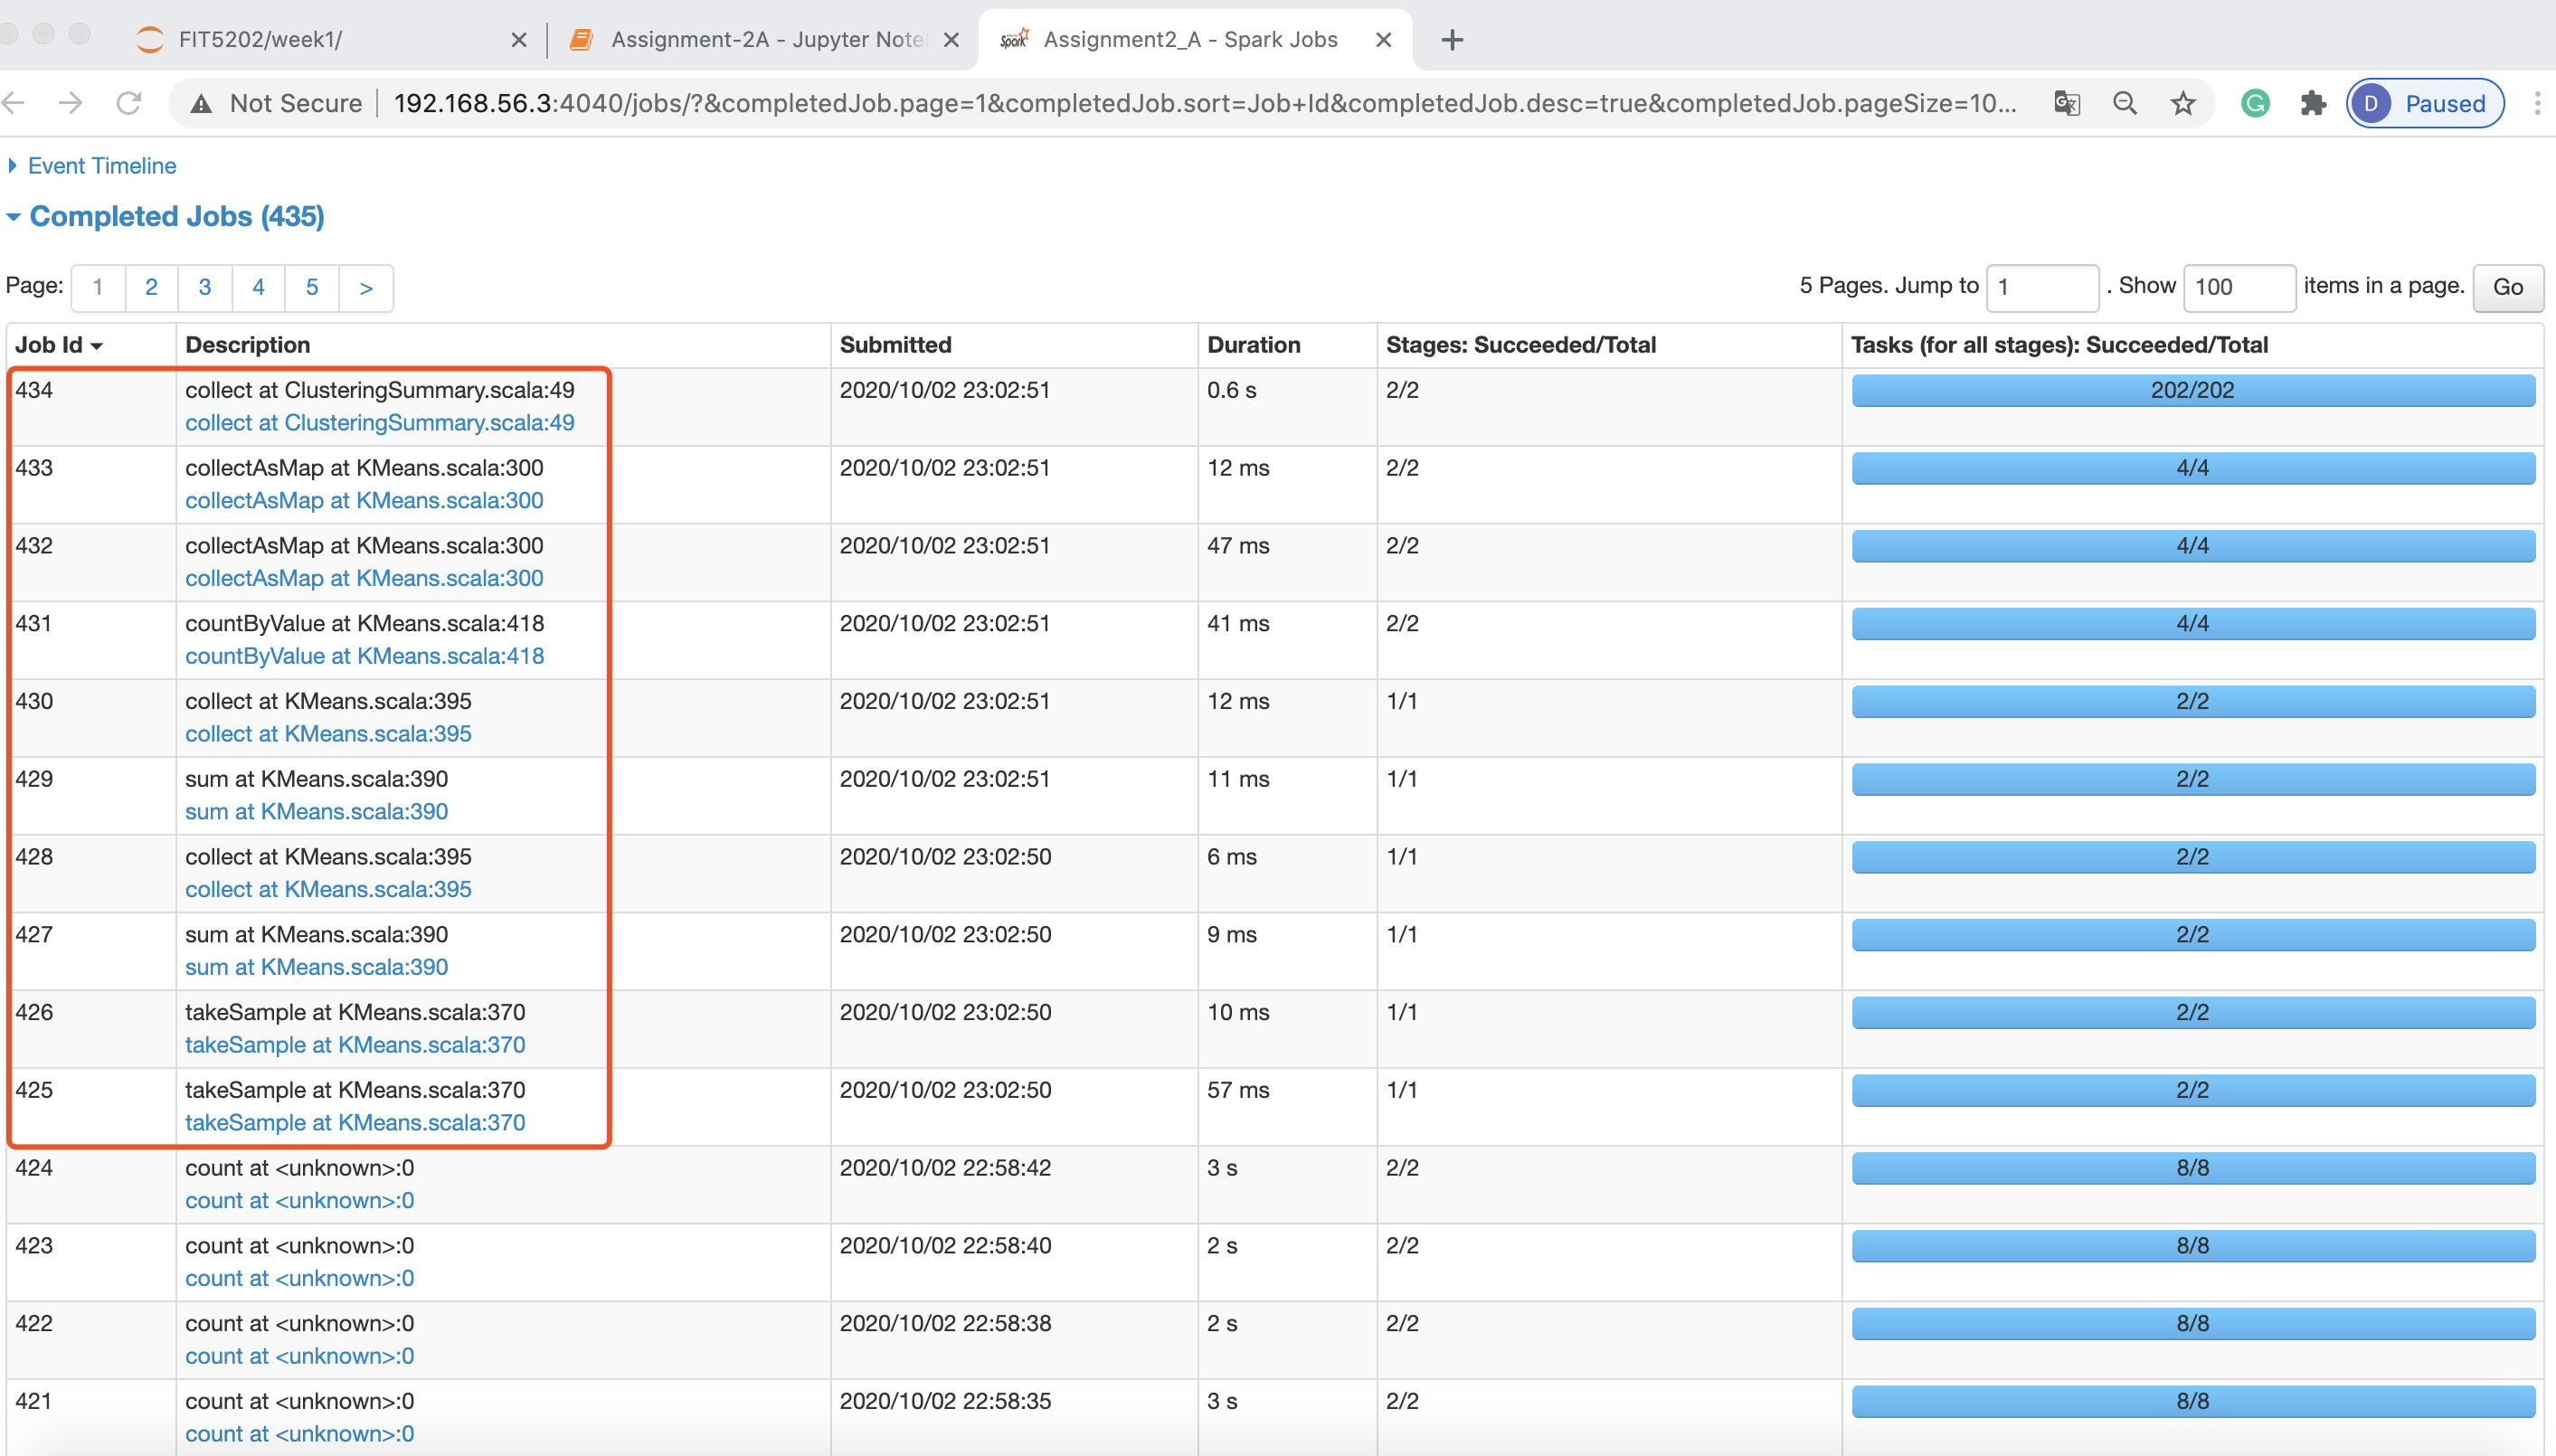

<font size=3 color=blue > 3.2

### explanation:
When using the above code to train the KMeans cluster model, according to the observation of Spark UI, we can see that there are 10 jobs.
1.We can see that there are two 'takeSample at KMeans.scala:370', which is used to initKMeansParallel.
2.'sum at KMeans.scala:390', This job is to aggregate the results of the above sampling.
3.'countByValue at KMeans.scala:418', Calculate the shortest distance between the sample point and the new center point.And update the cluster centers and costs
4.collectAsMap at KMeans.scala:300.This process continues to loop and iterate. 
5.collect at ClusteringSummary.scala:49. Finally, it might have a set of more than k distinct candidate centers; weight each candidate by the number of points in the dataset mapping to it and run a local k-means on the weighted centers to pick k of them.